In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdoc
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [7]:
pkl_file = open('train.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

In [8]:
class YieldClustering:

    def __init__(self, data):
        self.data = data
        self.wcss = {}
        self.clusters = 0

    def get_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """ get only the features which are used for clustering
        """
        data = data[['Low Emergence_mean', 'New yield risk_mean', 'Nutrient Deficiency_mean', 'Replant Risk_mean',
                     'harvest_mean']]
        return data

    def data_scale(self, data: pd.DataFrame) -> pd.DataFrame:
        """ scale features using Standard Scaler
        """
        scale_norm = StandardScaler()
        scale_norm.fit(data)
        scale_data = scale_norm.transform(data)
        pickle.dump(scale_norm, open('scale_norm.pkl', 'wb'))

        return scale_data

    def elbow_method(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        using elbow method function returns the best three number of clus

        """
        epsilon, best_cluster = 0.1, 0
        for i in range(1, 15):
            k_means = KMeans(n_clusters=i)
            k_means.fit(data)
            self.wcss[i] = k_means.inertia_
            if i > 1 and best_cluster == 0 and abs(self.wcss[i] / self.wcss[i - 1] - 1) < epsilon:
                best_cluster = i - 1
        plt.plot(range(1, 15), self.wcss.values())
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.close()
        plt.savefig('Elbow_method')

        return [best_cluster - 1, best_cluster, best_cluster + 1]

    def get_silhouette_score(self, estimator: KMeans, X: pd.DataFrame) -> float:
        """ calculate silhouette_score for the given model and feature set
        Args:
            estimator: kmeans model
            X: feature set for model training

        Returns:
            silhouette_score
        """
        labels = estimator.fit_predict(X)
        score = sklearn.metrics.silhouette_score(X, labels, metric='euclidean')

        return score

    def train(self):
        """ train kmeans and save best model
        """
        data = self.get_data(self.data)
        scale_data = self.data_scale(data)
        best_clusters = self.elbow_method(scale_data)
        params = {'n_clusters': best_clusters, "init": ['k-means++', 'random'], "max_iter": [100, 200, 300],
                  "n_init": [10, 15, 20]}
        search = GridSearchCV(KMeans(random_state=0), param_grid=params, scoring=self.get_silhouette_score)
        search.fit(scale_data)
        best_params = search.best_params_
        model = KMeans(random_state=0, n_clusters=best_params['n_clusters'], init=best_params['init'],
                       max_iter=best_params['max_iter'], n_init=best_params['n_init'])

        model.fit(scale_data)

        with open("kmeans_model.pkl", "wb") as f:
            pickle.dump(model, f)

        self.model = model

    def get_prediction(self, data: pd.DataFrame = None) -> pd.DataFrame:
        """ predict clusters for given data, if data is None, prediction is done for train data
        
        Args:
            data: feature set for prediction

        Returns: the same df with cluster predictions
        """

        if data is None:
            data = self.data

        data = self.get_data(self.data)
        sc = pickle.load(open('scale_norm.pkl', 'rb'))
        scale_data = sc.transform(data)

        with open("kmeans_model.pkl", "rb") as f:
            model = pickle.load(f)
        data['cluster'] = model.predict(scale_data)
        self.clusters = model.n_clusters

        return data

    def get_featues_mean_for_clusters(self, data: pd.DataFrame) -> dict:
        """ calculate features' mean for each group, as well for whole data
        """

        data_cluster = {}
        for i in np.unique(data.cluster):
            data_cluster[i] = data[data['cluster'] == i]

        feature_values = {}
        for j in data.columns:
            lst = []
            for i in range(self.clusters):
                lst.append(data_cluster[i][j].mean())
            lst.append(data[j].mean())
            feature_values[j] = lst
        return feature_values

    def cluster_analysis(self, data: pd.DataFrame = None):
        """ plot alert features means by groups based on clustering,
        if data is None, prediction is done for train data
        """
        if data is None:
            data = self.data

        groups = []
        data = self.get_prediction(data)
        feature_values = self.get_featues_mean_for_clusters(data)
        for i in range(self.clusters):
            groups.append(f'group{i + 1}')
        groups.append("All Data")
        data_plot = pd.DataFrame({f'{data.columns[0]}': feature_values[data.columns[0]],
                                  f'{data.columns[1]}': feature_values[data.columns[1]],
                                  f'{data.columns[2]}': feature_values[data.columns[2]],
                                  f'{data.columns[3]}': feature_values[data.columns[3]]}, index=groups)

        data_plot.plot(kind="bar")
        axes2 = plt.twinx()
        plt.title("Cluster Analysis")
        plt.ylabel('alert features, mean')
        axes2.plot(groups, feature_values['harvest_mean'], color='green', marker='o', linestyle='dashed', linewidth=2,
                   markersize=12)
        axes2.set_ylabel('harvest_mean, mean')
        plt.ylim(180, 250)
        plt.show


In [9]:
kmeans_analysis = YieldClustering(data)

In [10]:
kmeans_analysis.train()

<Figure size 432x288 with 0 Axes>

In [11]:
kmeans_analysis.model

KMeans(max_iter=100, n_clusters=5, n_init=15, random_state=0)

In [12]:
kmeans_analysis.get_prediction()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Low Emergence_mean,New yield risk_mean,Nutrient Deficiency_mean,Replant Risk_mean,harvest_mean,cluster
0,0.854710,0.722707,0.000000,0.0,174.499496,4
1,0.841044,0.346638,0.000883,0.0,211.255692,4
2,0.117885,0.526473,0.243028,0.0,189.610092,1
4,0.091827,0.699622,0.306191,0.0,174.854385,1
5,0.078351,0.672237,0.000000,0.0,231.198898,1
...,...,...,...,...,...,...
7,0.000000,0.080196,0.024455,0.0,236.343155,0
8,0.000000,0.080293,0.024159,0.0,232.948776,0
9,0.001870,0.111908,0.027459,0.0,233.594147,0
10,0.320803,0.030918,0.000000,0.0,231.707611,0


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


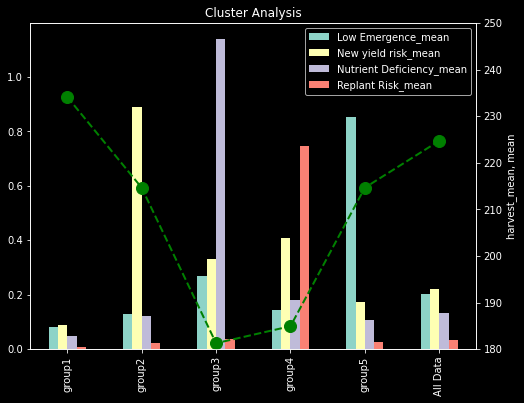

In [13]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (8,6)
kmeans_analysis.cluster_analysis()

#### Summary:  
####  In group3 and group4 where harvest_mean is significantly less than the average for the whole data, Nutrient Deficiency (in group3) and Replant Risk (as well New yield risk in group4) are higher compared to the whole data
#### In group2 (New yield risk is high) and  group5 (Low Emergence is high) harvest_mean is less, but the difference is not significantly.
#### In group1 where all features' values are less than those for the whole data, harvest mean is higher